## 0. Import Libraries

In [1]:
from datetime import datetime, timedelta
from glob import glob

import numpy as np
import pandas as pd
import pyproj
import rioxarray
import salem
import xarray as xr
from shapely.geometry import mapping

import cartopy
import matplotlib.pyplot as plt
import proplot
from matplotlib.colors import BoundaryNorm, ListedColormap
from cartopy.feature import ShapelyFeature
from cartopy.io.shapereader import Reader

/home/donmezk16/Downloads/anaconda3/envs/AFAD/lib/python3.9/site-packages/proplot/__init__.py:30: ProplotWarning: Found conflicting default user proplot folders at '/home/donmezk16/.proplot' and '/home/donmezk16/.config/proplot'. Ignoring the second one.
  from .config import *  # noqa: F401 F403
/home/donmezk16/Downloads/anaconda3/envs/AFAD/lib/python3.9/site-packages/proplot/__init__.py:30: ProplotWarning: Found conflicting default user proplot folders at '/home/donmezk16/.proplot' and '/home/donmezk16/.config/proplot'. Ignoring the second one.
  from .config import *  # noqa: F401 F403
/home/donmezk16/Downloads/anaconda3/envs/AFAD/lib/python3.9/site-packages/proplot/__init__.py:30: ProplotWarning: Found conflicting default user proplot folders at '/home/donmezk16/.proplot' and '/home/donmezk16/.config/proplot'. Ignoring the second one.
  from .config import *  # noqa: F401 F403
/home/donmezk16/Downloads/anaconda3/envs/AFAD/lib/python3.9/site-packages/proplot/__init__.py:30: ProplotW

## 1. Open Datasets

### 1.1 Options

In [2]:
run_season = 'spring'
variable = 'PRCP'
general_path = 'data'
start_utc = 11
end_utc = 15

# ensemble members
micro_options = [
    'lin',
    'thompson',
    'wsm6'
]

luse_options = [
    'urban',
    'nourban'
]

# data path
data_path = glob(fr'{general_path}/*{run_season}*')

## 2. Open Data

In [3]:
# open data
dt = xr.open_mfdataset(data_path,
                       concat_dim='ens').isel(time=slice(start_utc, end_utc))[variable]

# instead of 201 grid we want 200 grid in each direction
dt = dt.isel(south_north=slice(0,200),
             west_east=slice(0,200))

# assign projection and dim info
dt = dt.rio.write_crs(dt.attrs['pyproj_srs'])
dt = dt.rio.set_spatial_dims(x_dim='west_east',
                             y_dim='south_north')

## 3. Find Ensemble Member Averages

### 3.1 Define Members

In [4]:
# ensemble member list
ensemble_members = list(dt.ens.values)

# urban and nourban members
urban_members = [ens for ens in ensemble_members if not 'nourban' in ens ]
nourban_members = [ens for ens in ensemble_members if 'nourban' in ens ]

### 3.2 Ensemble Mean For Urban and Nourban

In [5]:
dt_urban_ens = dt.sel(ens=urban_members).mean(dim='ens')
dt_nourban_ens = dt.sel(ens=nourban_members).mean(dim='ens')

In [6]:
dt_ens_diff = dt_urban_ens - dt_nourban_ens

In [7]:
coarsen_dt = dt_ens_diff.coarsen(south_north=5, west_east=5).mean()

### 3.3 Sample Graphics

#### 3.3.1 Original - Urban Data

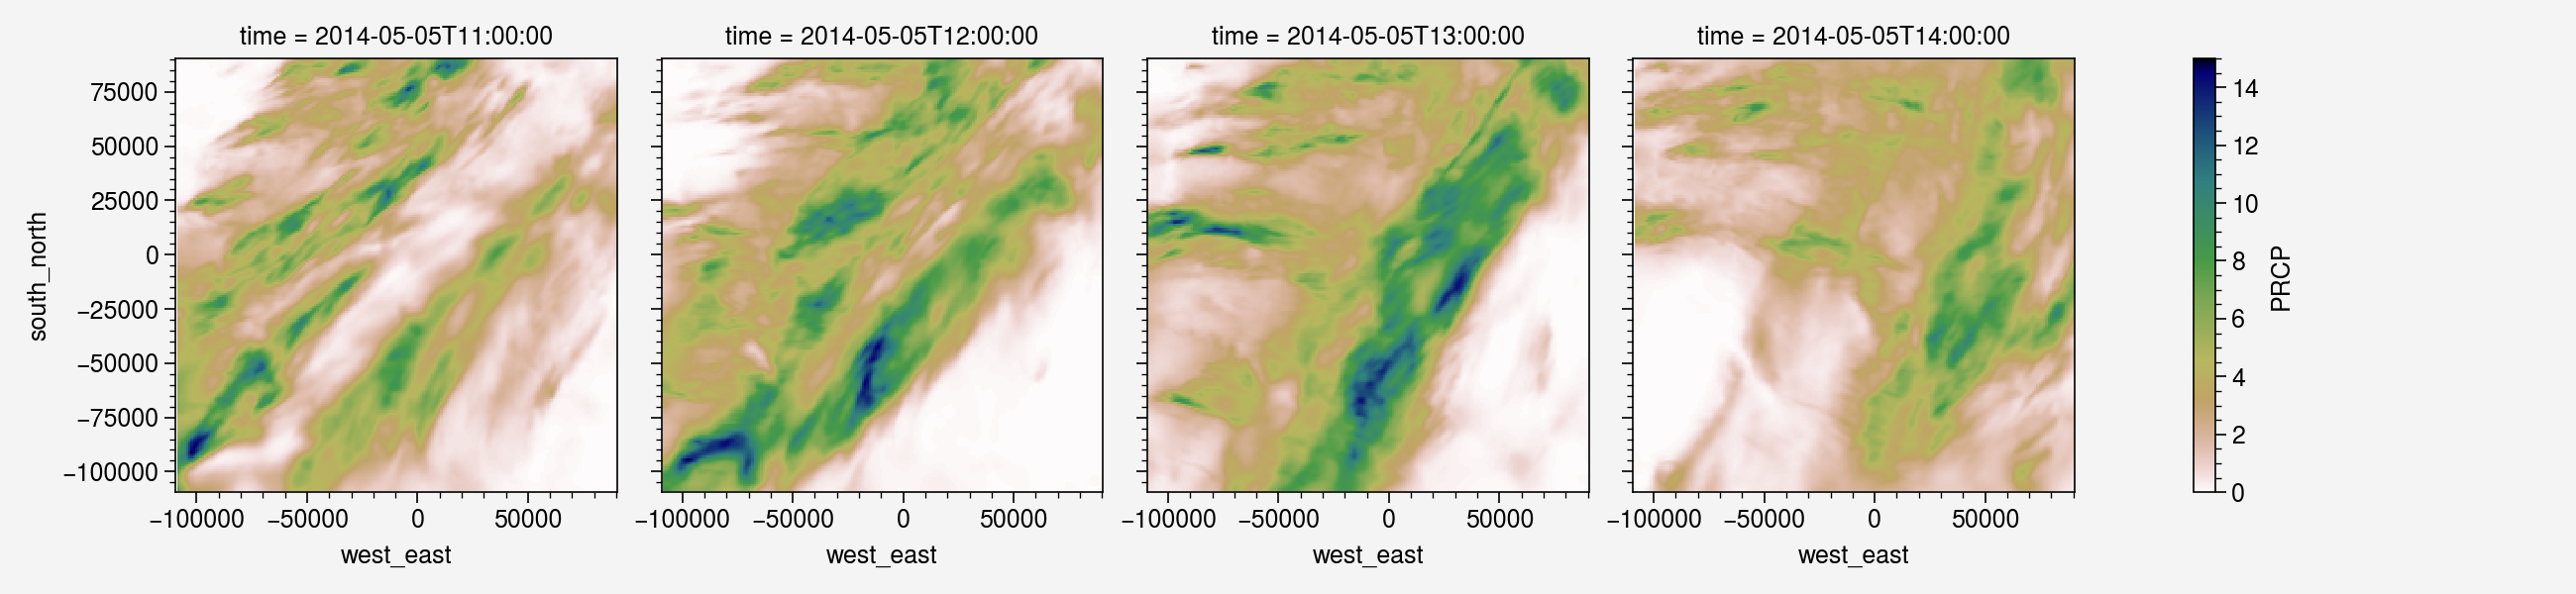

In [8]:
# sample original urban graphic
dt_urban_ens.plot(col='time', 
      col_wrap=4,
      vmin=0,
      vmax=15,
      cmap='gist_earth_r')

#### 3.3.2 Original - Norban Data

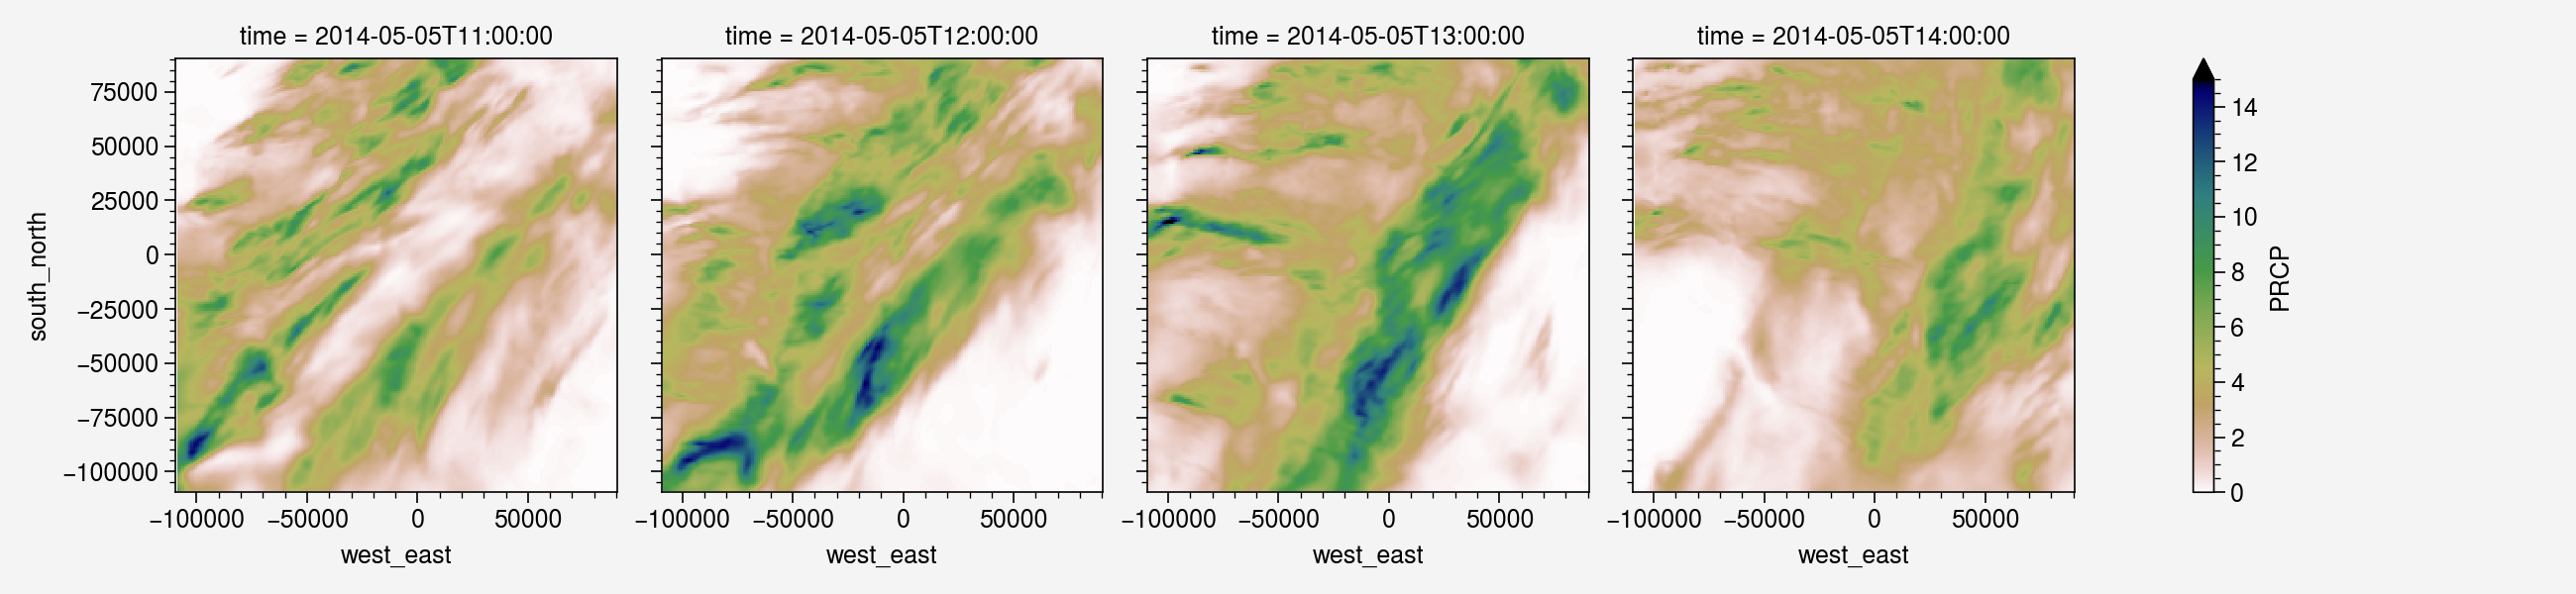

In [9]:
# sample original urban graphic
dt_nourban_ens.plot(col='time', 
      col_wrap=4,
      vmin=0,
      vmax=15,
      cmap='gist_earth_r')

#### 3.3.3 Original - Difference Data

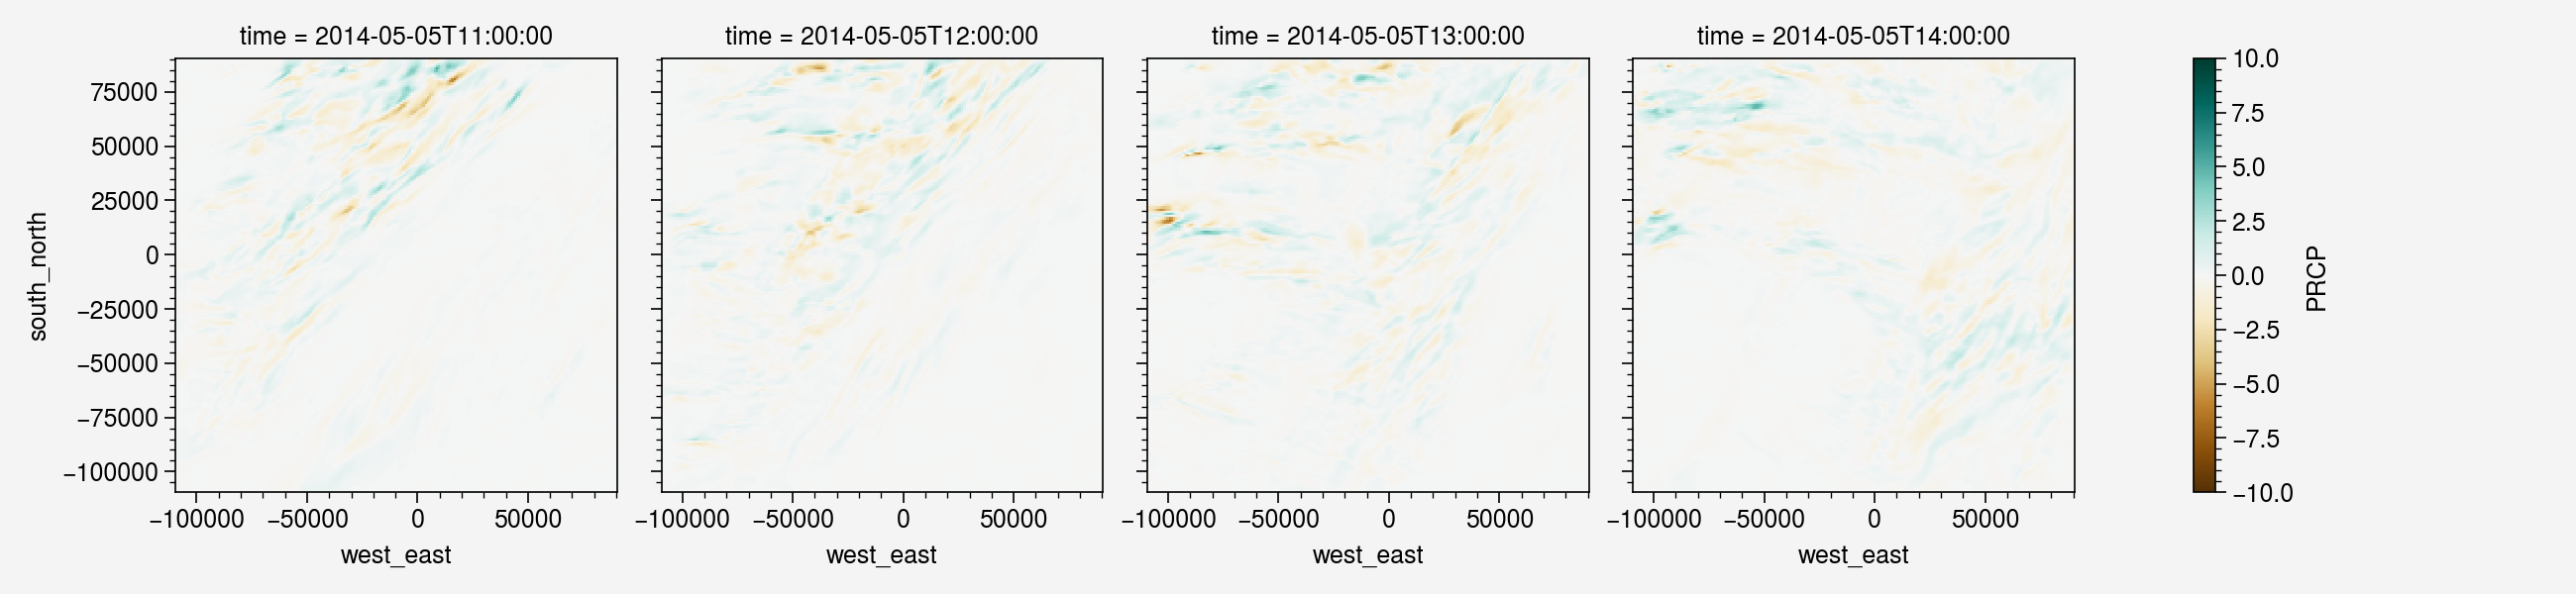

In [10]:
# sample original graphic
dt_ens_diff.plot(col='time', 
      col_wrap=4,
      vmin=-10,
      vmax=10,
      cmap='BrBG')

#### 3.3.4 Coarse - Difference Data

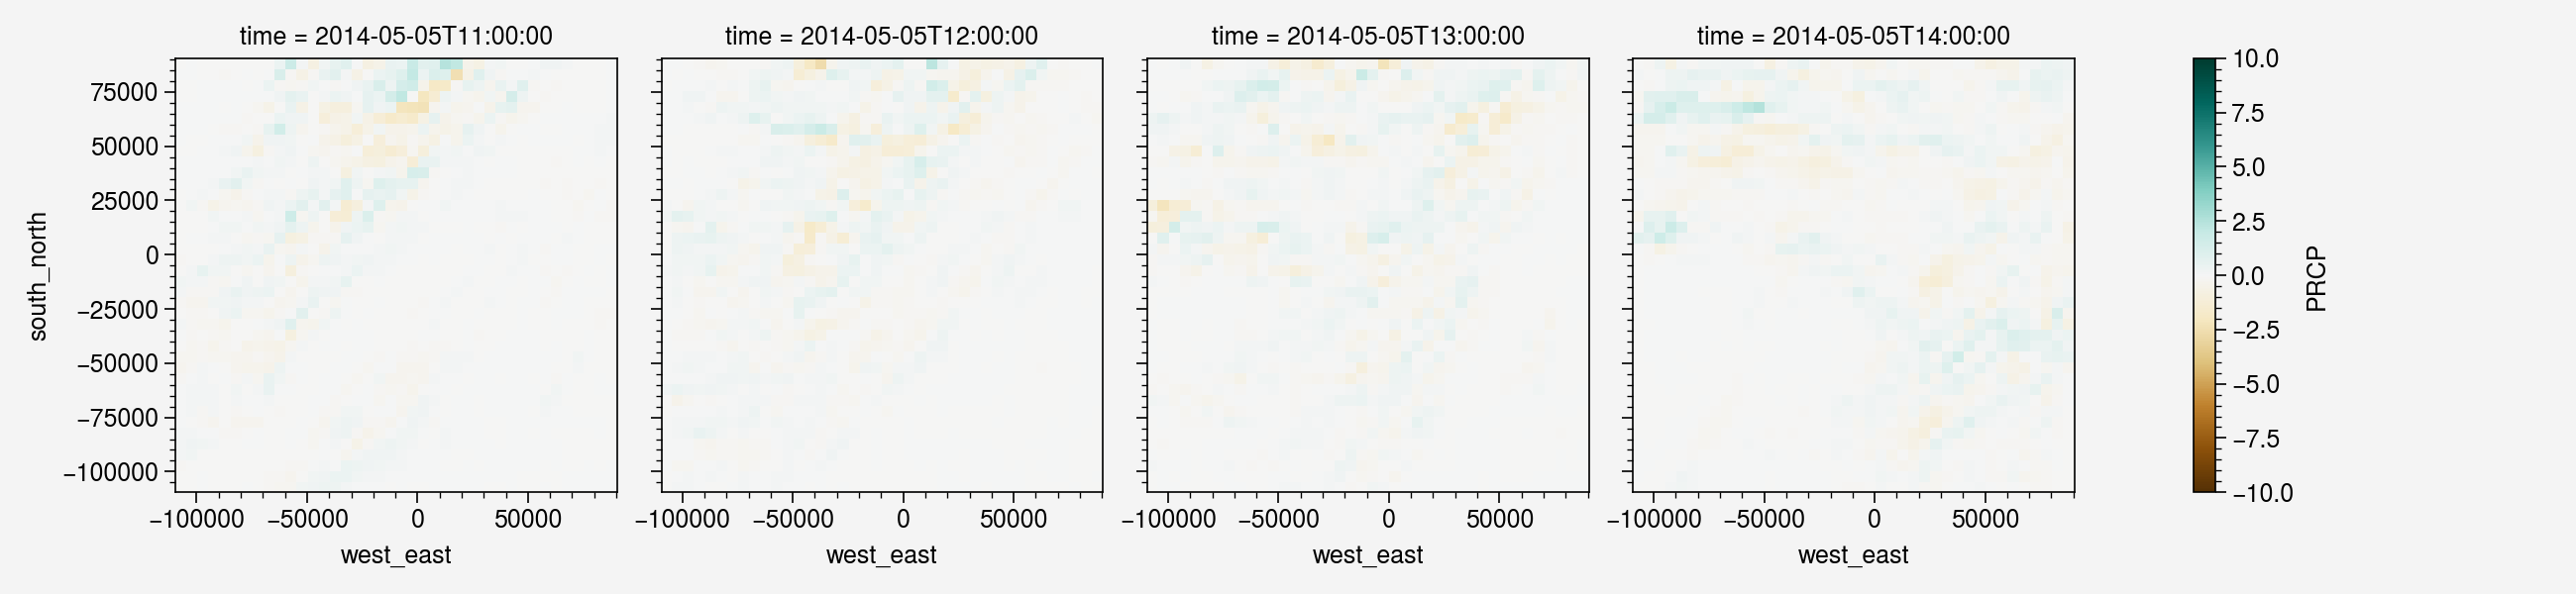

In [11]:
# sample coarse graphic
coarsen_dt.plot(col='time', 
      col_wrap=4,
      vmin=-10,
      vmax=10,
      cmap='BrBG')

## 4. Visualization

### 4.1 Open Land Use Datasets

In [19]:
luse_path = 'lu_index'
luse_var = 'LU_INDEX'
urban_luse_border = xr.open_dataset(fr'{general_path}/{luse_path}/urban_luse.nc')[luse_var]
nourban_luse_border = xr.open_dataset(fr'{general_path}/{luse_path}/nourban_luse.nc')[luse_var]

### 4.2 Parameters

In [26]:
# cmap for total urban and nourban hourly precipitation
nws_precip_colors_total = [
    "#FFFFFF",
    "#a9dff9",
    "#8acef5",
    "#67aae1", 
    "#4aa77a", 
    "#a2cf5a", 
    "#fed755", 
    "#f29a3e", 
    "#ef6934"]

cmap = ListedColormap(nws_precip_colors_total)

In [27]:
# Parameters to change (plot) -------------------
# projection
proj = dt.rio.crs.to_dict()
globe = cartopy.crs.Globe(ellipse='sphere', semimajor_axis=6370000, semiminor_axis=6370000)
lcc = cartopy.crs.LambertConformal(globe=globe, # important!
                            central_longitude=proj['lon_0'], 
                            central_latitude=proj['lat_0'],
                            standard_parallels=(proj['lat_1'], proj['lat_2']),
                            )

# fig features
fig_array = [[1, 2, 3, 4],
             [5, 6, 7, 8]
            ]
graphic_no = 8

# graphic vmin, vmax and norms
vmin = 0 # consider lower limit above
vmax = 16 # consider upper limit above

clevs_total = [0, 1, 2, 3, 4, 5, 7, 10, 14, 18]
norm = BoundaryNorm(clevs_total,
                    ncolors=cmap.N, 
                    clip=True)
ticks = clevs_total

### 4.3 Plot

/tmp/ipykernel_3010/825341258.py:2: ProplotWarning: Ignoring unused projection-specific format() keyword argument(s): {'aspect': 4}
  fig, axs = proplot.subplots(fig_array,


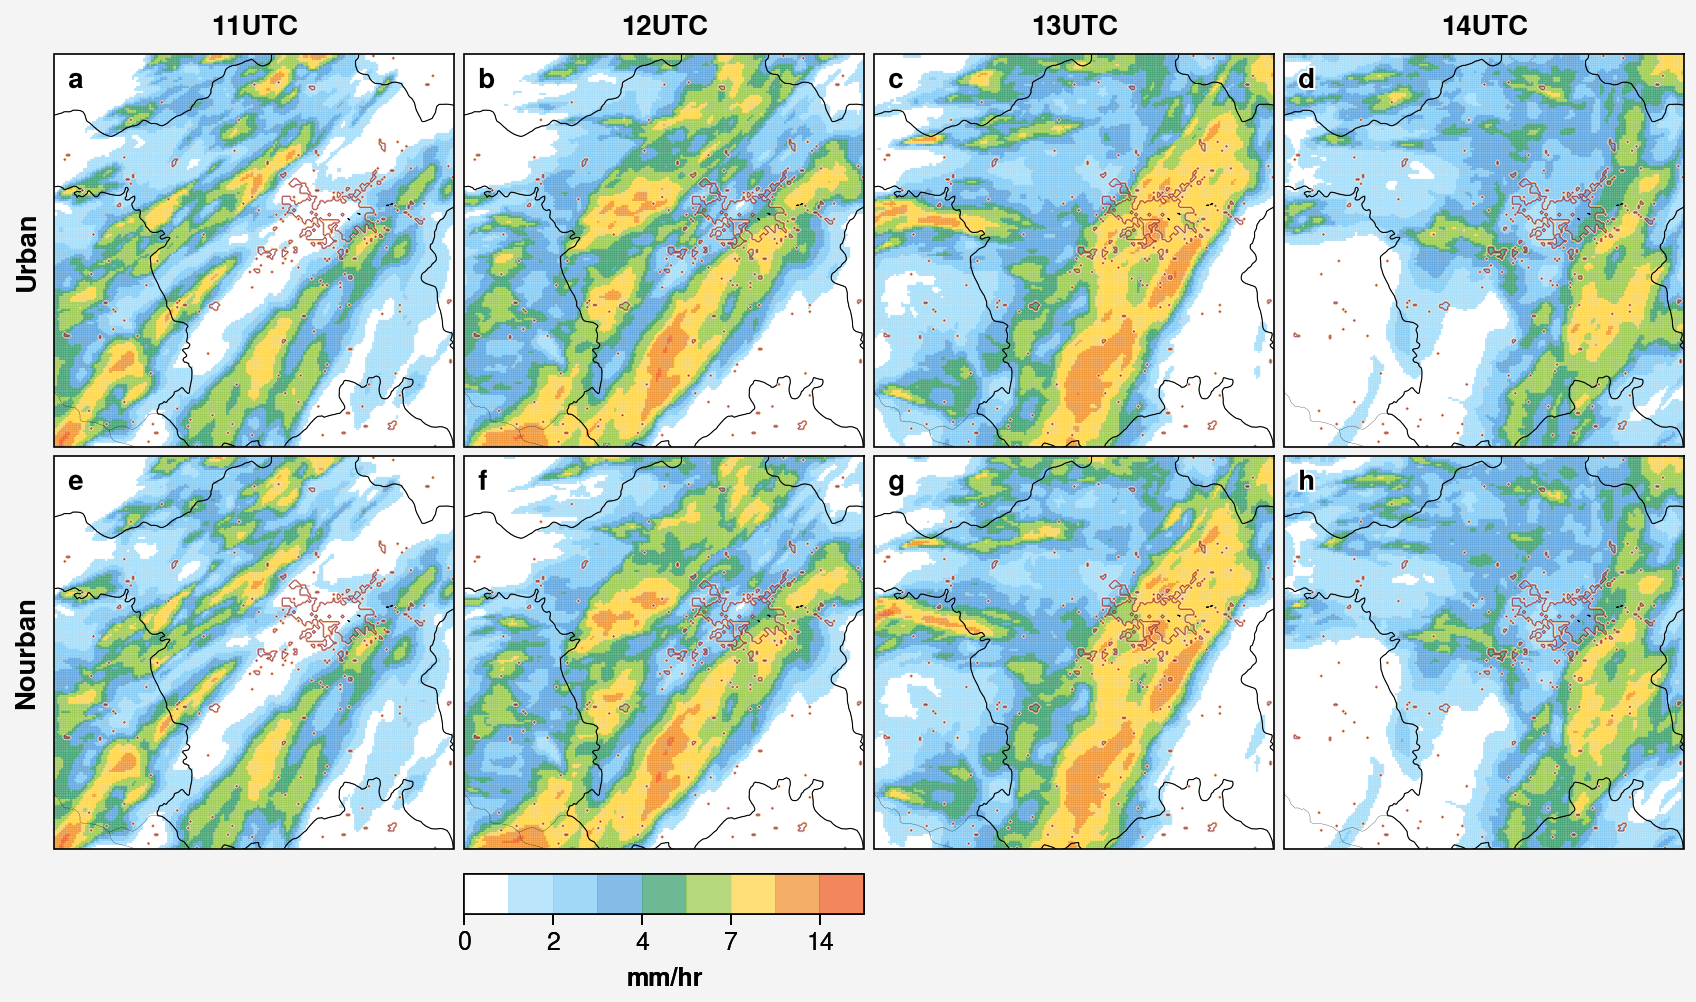

In [28]:
# Create Figure -------------------------
fig, axs = proplot.subplots(fig_array, 
                            aspect=4,
                            axwidth=2,
                            proj=lcc,
                            hratios=tuple(np.ones(len(fig_array), dtype=int)),
                            includepanels=True,
                            hspace=0.36,
                            wspace=0.4,
                            sharey=0)

# format whole figure
axs.format(abcloc='ul',
           abc=True,)

# ankara limits
axs.format(lonlim=(31.3, 33.4), 
           latlim=(39, 40.6), 
           labels=False, 
           longrid=False, 
           latgrid = False)

axs.format(rowlabels=['Urban', 'Nourban'],
           collabels=['11UTC', '12UTC', '13UTC', '14UTC']
           )
#proplot.rc['leftlabel.rotation'] = 'vertical'
proplot.rc.update({'leftlabel.rotation':'vertical'})

# add shapefiles
turkey_district_shape = r'data/shapefiles/ankara_province_shape.shp'
shape_district_turkey = ShapelyFeature(Reader(turkey_district_shape).geometries(),
                                             cartopy.crs.PlateCarree(), facecolor='none',
                                             edgecolor = 'black', linewidth = 0.4, zorder = 0.3)

turkey_province_shape = r'data/shapefiles/Iller_HGK_6360_Kanun_Sonrasi.shp'
shape_province_turkey = ShapelyFeature(Reader(turkey_province_shape).geometries(),
                                             cartopy.crs.PlateCarree(), facecolor='none',
                                             edgecolor = 'black', linewidth = 0.05, zorder = 0.4)

for i in range(graphic_no):
    axs[i].add_feature(shape_district_turkey)
    axs[i].add_feature(shape_province_turkey)   
    
dt_border = urban_luse_border
for t in range(8):
            
    if t < 4:
        dt_luse = dt_urban_ens
        #dt_border = urban_luse_border
        i = t
    else:
        dt_luse = dt_nourban_ens
        #dt_border = nourban_luse_border
        i = t-4
        
    mesh = axs[t].pcolormesh(dt_luse[i]['lon'], 
                            dt_luse[i]['lat'],
                            dt_luse[i], 
                            cmap = cmap,
                            norm=norm,
                            zorder = 0.2,
                            alpha=0.8)
    
    contour = axs[t].contour(dt_border['lon'], 
                            dt_border['lat'],
                            dt_border,
                            linewidth = 0.1
                            )

# colorbar
cbar = fig.colorbar(mesh,
                    label='mm/hr',
                    labelweight='bold',
                    ticks = ticks,
                    loc = 'b',
                    col=2
                   )